In [1]:
# !pip3 install medpy -i https://pypi.tuna.tsinghua.edu.cn/simple
# !pip3 install nibabel -i https://pypi.tuna.tsinghua.edu.cn/simple
# !pip3 install pynrrd -i https://pypi.tuna.tsinghua.edu.cn/simple

# pip3 install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -i https://pypi.tuna.tsinghua.edu.cn/simple

In [2]:
# cd dataloaders
# !python3 la_heart_processing.py

In [3]:
# !cd ../code
# !python3 train_VNet_CTM.py --batch_size 8 --gpu "3"  #,5,6,7"

In [4]:
# !python3 test_VNet_CTM.py --gpu '3'

## 后处理

### dice的violin图\箱图

,Unnamed: 0,bg,proximal_femur,distal_femur,fragment
0,100207091,0.996482,0.936998,0.882833,0.879821
1,100301649,0.994218,0.860520,0.891910,0.877653
2,100658440,0.996401,0.911564,0.874734,0.763328
3,100752370,0.997263,0.941296,0.852361,0.784180
4,100903938,0.996095,0.906737,0.874781,0.774058


   Unnamed: 0        bg  proximal_femur  distal_femur  fragment
0   100207091  0.996482        0.936998      0.882833  0.879821
1   100301649  0.994218        0.860520      0.891910  0.877653
2   100658440  0.996401        0.911564      0.874734  0.763328
3   100752370  0.997263        0.941296      0.852361  0.784180
4   100903938  0.996095        0.906737      0.874781  0.774058
5   100067245  0.998278        0.930174      0.897724  0.745003
7   100201344  0.994184        0.926298      0.819133  0.804970


,dice,category,patient
0,0.996482,bg,100207091
1,0.994218,bg,100301649
2,0.996401,bg,100658440
3,0.997263,bg,100752370
4,0.996095,bg,100903938


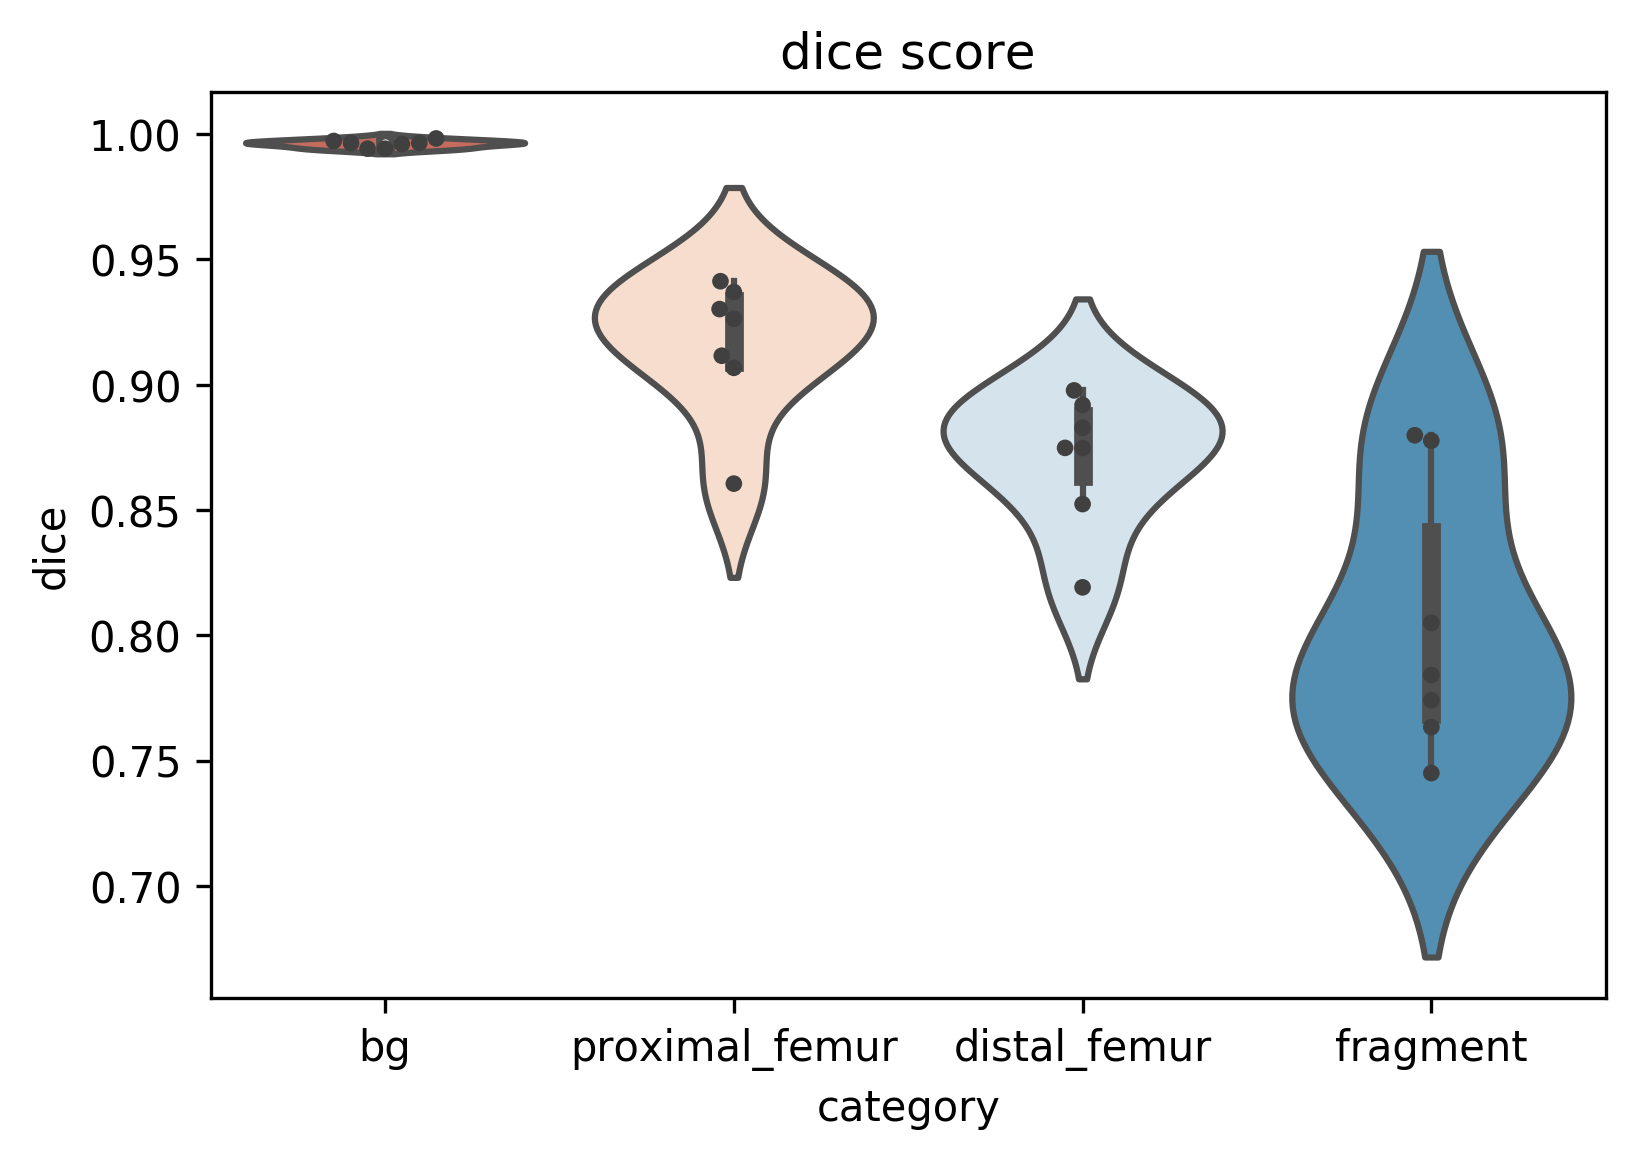

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

filename = "../model/prediction/vnet_supervisedonly_dp_post/metrics_test_set.csv"
results_raw = pd.read_csv(filename)
display(results_raw.head())

# 删除异常样本
results_raw = results_raw.drop(results_raw[results_raw['fragment']<0.65].index)
print(results_raw)

# 重新整理数据表,以便适应sns.violinplot
proc_df = pd.DataFrame(columns=['dice','category','patient'])
proc_df = pd.DataFrame(columns=['dice','category','patient'])
proc_df.dice = pd.to_numeric(pd.concat([results_raw.bg,results_raw.proximal_femur,results_raw.distal_femur,results_raw.fragment]))
proc_df.category = ['bg']*len(results_raw)+['proximal_femur']*len(results_raw)+['distal_femur']*len(results_raw)+['fragment']*len(results_raw)
proc_df.patient = pd.concat([results_raw['Unnamed: 0'],results_raw['Unnamed: 0'],results_raw['Unnamed: 0'],results_raw['Unnamed: 0']]).values
proc_df.dice = proc_df.dice.astype('float')
proc_df.category = proc_df.category.astype('category')

# https://cloud.tencent.com/developer/article/1486970
display(proc_df.head())
plt.figure(dpi=300)
ax = sns.violinplot( data=proc_df, x='category', y='dice', order=['bg','proximal_femur','distal_femur','fragment'],scale="width",palette = 'RdBu' )
ax = sns.swarmplot(data=proc_df, x='category', y='dice', order=['bg','proximal_femur','distal_femur','fragment'], color=".25", size=4)
# 添加图形标题
plt.title('dice score')
# 保存图片
results_dir = "../result"
filename=os.path.join(results_dir,'voilinplot of pred dice-score on test-set.png')
plt.savefig(filename)
# 显示图形
plt.show()

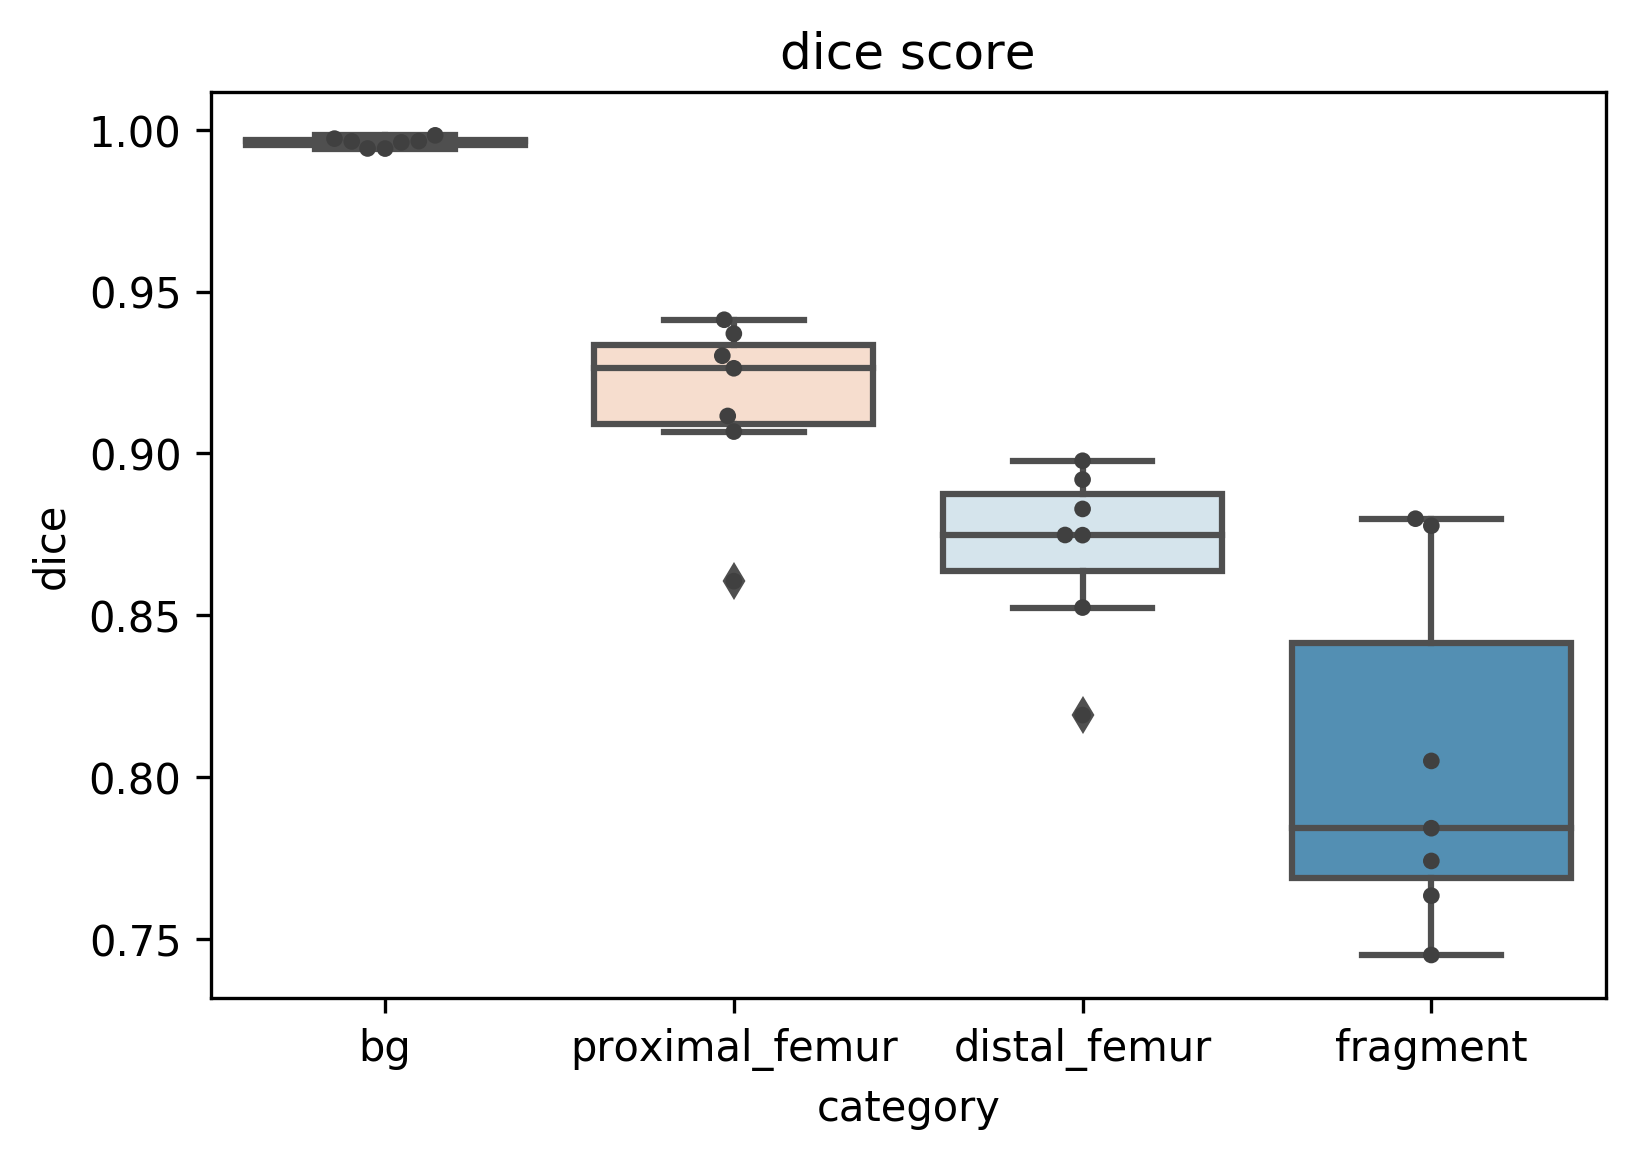

In [44]:
plt.figure(dpi=300)
ax = sns.boxplot(data=proc_df, x='category', y='dice', order=['bg','proximal_femur','distal_femur','fragment'], palette = 'RdBu')
ax = sns.swarmplot(data=proc_df, x='category', y='dice', order=['bg','proximal_femur','distal_femur','fragment'], color=".25", size=4)
# 添加图形标题
plt.title('dice score')
# 保存图片
filename=os.path.join(results_dir,'boxplot of pred dice-score on test-set.png')
plt.savefig(filename)
# 显示图形
plt.show()

### 画自动分割mask对比图

In [45]:
patients = results_raw['Unnamed: 0'].values
display(patients)

array([100207091, 100301649, 100658440, 100752370, 100903938, 100067245,
       100201344])

In [46]:
results_dir = "../model/prediction/vnet_supervisedonly_dp_post"
import os
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk

import torch
import torchvision
import torchvision.transforms as transforms


patients = results_raw['Unnamed: 0'].values
images = tuple()
n_case = 7
H, W = 140, 140
for patient in patients[:10]:
    image_sitk = sitk.ReadImage(os.path.join(results_dir, str(patient)+'_img.nii.gz'))
    label_gt_sitk = sitk.ReadImage(os.path.join(results_dir, str(patient)+'_gt.nii.gz'))
    label_pred_sitk = sitk.ReadImage(os.path.join(results_dir, str(patient)+'_pred.nii.gz'))

    image = sitk.GetArrayFromImage(image_sitk).transpose([2,1,0])
    image = (image-image.min())/(image.max()-image.min())*255
    label_gt = sitk.GetArrayFromImage(label_gt_sitk).transpose([2,1,0])/2*255
    label_pred = sitk.GetArrayFromImage(label_pred_sitk).transpose([2,1,0])/2*255

    # 图像必须大小相同
    hmin,hmax = int((image.shape[0]-H)/2), int((image.shape[0]-H)/2+H)
    wmin,wmax = int((image.shape[1]-W)/2), int((image.shape[1]-W)/2+W)
    image = image[hmin:hmax,wmin:wmax,:]
    label_gt = label_gt[hmin:hmax,wmin:wmax,:]

    label_pred = label_pred[hmin:hmax,wmin:wmax,:]
    # case 拼接
    numd = []
    for d in range(label_gt.shape[2]):
        numd.append( len(np.where(label_gt[:,:,d].flatten()==255)[0]) )
    numd = np.array(numd)
    slice = np.where(numd==numd.max())[0][0]
#     print('slice',slice)
    images = images+(image[:,:,slice][np.newaxis,np.newaxis,:,:],
                     label_gt[:,:,slice][np.newaxis,np.newaxis,:,:], 
                     label_pred[:,:,slice][np.newaxis,np.newaxis,:,:])
images = np.concatenate(images, axis=0)
print(images.shape)
print('np.unique(images):',np.unique(images))
images = torch.tensor(images)


(21, 1, 140, 140)
np.unique(images): [0.0000000e+00 1.0059116e-01 1.0224070e-01 ... 2.4768915e+02 2.5500000e+02
 3.8250000e+02]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


382.5
0.0
../result/pred_mask vs gt_mask.png


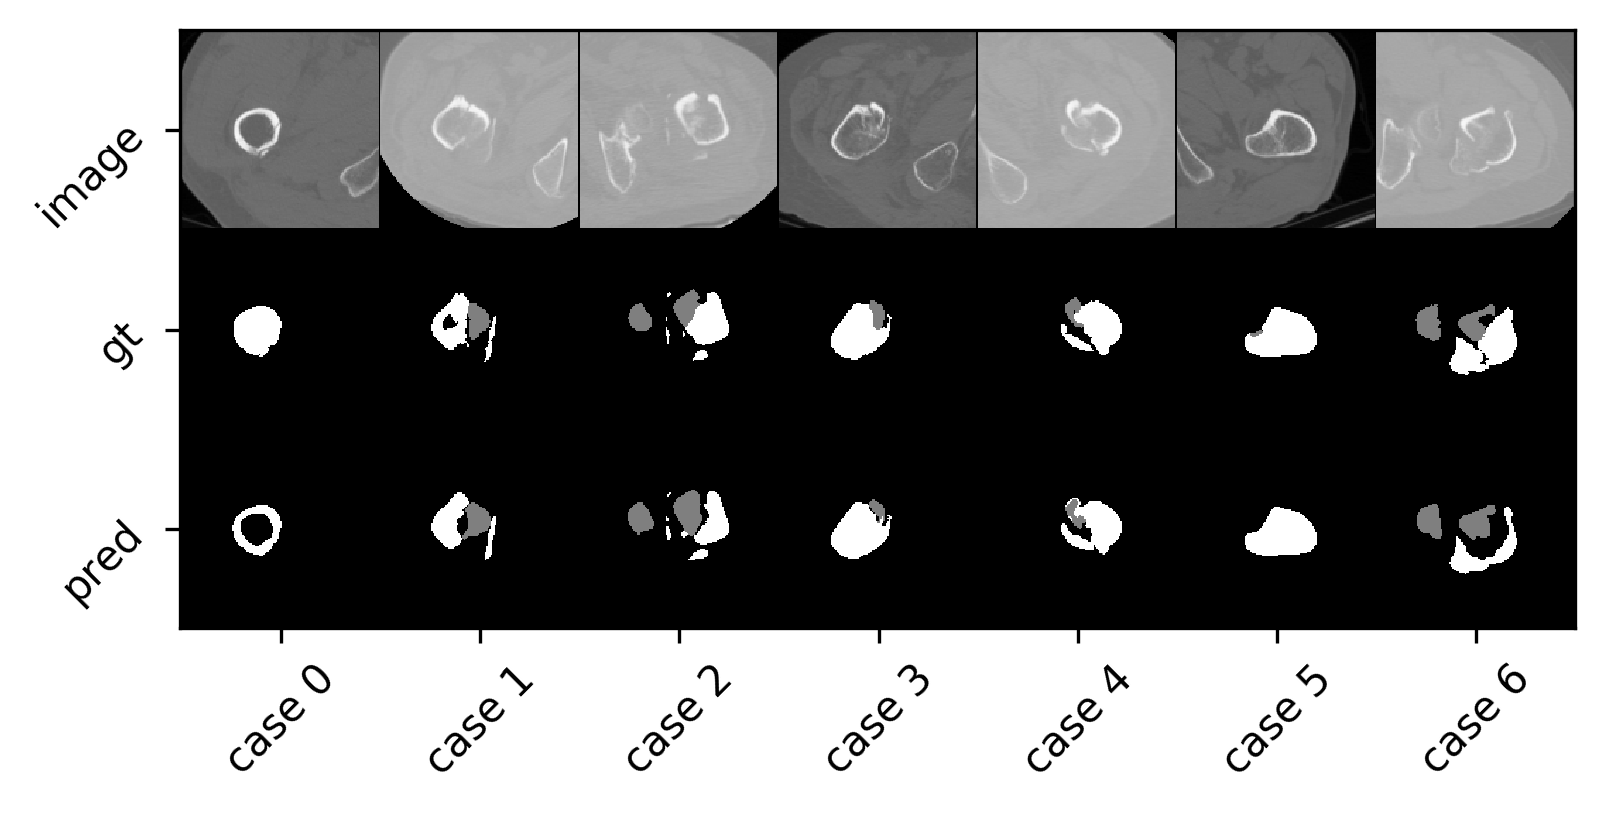

In [47]:
# functions to show an image
results_dir = "../result"

def imshow(img,n_case,filename):
    fig = plt.figure( dpi=300, frameon=False)
#     print(np.unique(img))
    npimg = img.numpy()
    npimg = np.transpose(npimg, (2, 1, 0))
    print(np.max(npimg))
    print(np.min(npimg))
    plt.imshow(npimg.astype(int),cmap='plasma')#一定要转为int
#     print(np.unique(npimg))
    xticks = [npimg.shape[1]/n_case*(i+0.5) for i in range(n_case)]
    yticks = [npimg.shape[0]/3*0.5,npimg.shape[0]/3*1.5,npimg.shape[0]/3*2.5]
    xlabels = ['case '+str(int(i)) for i in range(n_case)]
#     print(yticks)
    plt.xticks(xticks, xlabels,rotation=45) 
    plt.yticks(yticks, ['image', 'gt', 'pred'],rotation=45)
    plt.savefig(filename)
    print(filename)
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images, nrow=3, padding=1), 
       n_case=n_case,
       filename=os.path.join(results_dir,'pred_mask vs gt_mask.png')
      )
